In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install librosa pyAudioAnalysis pyannote.audio scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 MB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.5/58.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **Imports**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
from scipy.fftpack import dct
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os
from scipy.io.wavfile import write


# **Feature Extraction From Audio**

In [ ]:
def get_linear_filterbanks(num_filters, n_fft, sr):
    min_freq = 0
    max_freq = sr / 2
    lin_bins = np.linspace(min_freq, max_freq, num_filters + 2)
    filter_bank = np.zeros((num_filters, int(n_fft / 2 + 1)))

    fft_freqs = np.linspace(0, max_freq, int(n_fft / 2 + 1))
    for i in range(1, num_filters + 1):
        left = lin_bins[i - 1]
        center = lin_bins[i]
        right = lin_bins[i + 1]

        for j, freq in enumerate(fft_freqs):
            if left <= freq <= center:
                filter_bank[i - 1, j] = (freq - left) / (center - left)
            elif center < freq <= right:
                filter_bank[i - 1, j] = (right - freq) / (right - center)

    return filter_bank

def compute_mlfcc(signal, sr, num_filters=26, n_fft=512, n_mlfcc=13, hop_length=32000):

    stft = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))**2

    filter_bank = get_linear_filterbanks(num_filters, n_fft, sr)
    features = np.dot(filter_bank, stft)
    features = np.log(features + 1e-10)
    mlfcc = dct(features, type=2, axis=0, norm='ortho')[1:n_mlfcc + 1]

    return mlfcc.T

audio_file = '/content/drive/MyDrive/S01_U02.CH1.wav'
signal, sr = librosa.load(audio_file, sr=None)
mlfcc_features = compute_mlfcc(signal, sr)
print( mlfcc_features.shape)


(3064, 13)


# **Dimensionality Reduction and Elbow Curve**

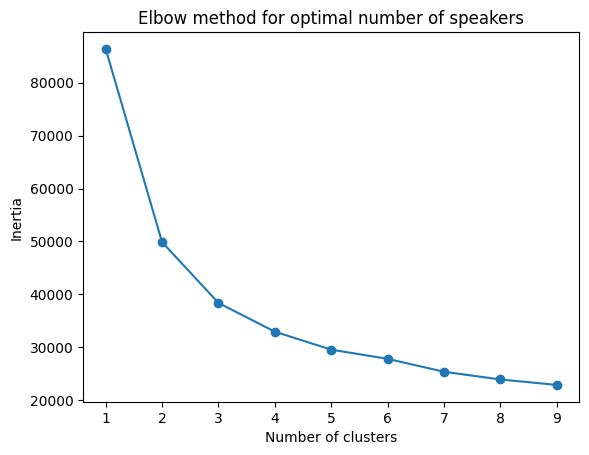

In [ ]:
pca = PCA(n_components=4)
reduced_features = pca.fit_transform(mlfcc_features)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(reduced_features)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method for optimal number of speakers')
plt.show()


# **Estimating number of speakers**

In [ ]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=0).fit(reduced_features)
labels = kmeans.labels_
unique_speakers = np.unique(labels)
num_speakers = len(unique_speakers)
print(f"Estimated number of unique speakers: {num_speakers}")

Estimated number of unique speakers: 4


# **Extracting Time stamps**

In [ ]:
hop_length =32000
frame_duration = hop_length / sr  # Duration of each frame in seconds
timestamps = []

current_speaker = labels[0]
start_time = 0

for i in range(1, len(labels)):
    if labels[i] != current_speaker:
        # Calculate end time of the segment for the current speaker
        end_time = i * frame_duration
        segment_duration = end_time - start_time

        # Only add segment if it's above a minimum duration (e.g., 2 seconds)
        if segment_duration >= 2.0:
            timestamps.append((current_speaker, start_time, end_time))

        # Update for the new speaker
        current_speaker = labels[i]
        start_time = end_time

# Add the last segment for the last speaker
end_time = len(labels) * frame_duration
segment_duration = end_time - start_time
if segment_duration >= 2.0:
    timestamps.append((current_speaker, start_time, end_time))

# Print timestamps for each speaker segment
for speaker_id, start, end in timestamps:
    print(f"Speaker {speaker_id}: Start = {start:.2f}s, End = {end:.2f}s, Duration = {end - start:.2f}s")


Speaker 2: Start = 0.00s, End = 2.00s, Duration = 2.00s
Speaker 1: Start = 2.00s, End = 4.00s, Duration = 2.00s
Speaker 0: Start = 4.00s, End = 10.00s, Duration = 6.00s
Speaker 2: Start = 10.00s, End = 12.00s, Duration = 2.00s
Speaker 3: Start = 12.00s, End = 14.00s, Duration = 2.00s
Speaker 0: Start = 14.00s, End = 16.00s, Duration = 2.00s
Speaker 1: Start = 16.00s, End = 18.00s, Duration = 2.00s
Speaker 0: Start = 18.00s, End = 20.00s, Duration = 2.00s
Speaker 1: Start = 20.00s, End = 24.00s, Duration = 4.00s
Speaker 0: Start = 24.00s, End = 26.00s, Duration = 2.00s
Speaker 1: Start = 26.00s, End = 28.00s, Duration = 2.00s
Speaker 0: Start = 28.00s, End = 30.00s, Duration = 2.00s
Speaker 2: Start = 30.00s, End = 32.00s, Duration = 2.00s
Speaker 0: Start = 32.00s, End = 36.00s, Duration = 4.00s
Speaker 1: Start = 36.00s, End = 38.00s, Duration = 2.00s
Speaker 0: Start = 38.00s, End = 40.00s, Duration = 2.00s
Speaker 2: Start = 40.00s, End = 42.00s, Duration = 2.00s
Speaker 0: Start = 

# **Saving the audio files**

In [ ]:
output_dir = "speaker_segments"
os.makedirs(output_dir, exist_ok=True)

for idx, (speaker_id, start, end) in enumerate(timestamps):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    speaker_audio = signal[start_sample:end_sample]
    output_path = os.path.join(output_dir, f"speaker_{speaker_id}_segment_{idx}.wav")
    write(output_path, sr, (speaker_audio * 32767).astype(np.int16))
    print(f"Saved {output_path}")

print("All segments saved successfully!")

Saved speaker_segments/speaker_2_segment_0.wav
Saved speaker_segments/speaker_1_segment_1.wav
Saved speaker_segments/speaker_0_segment_2.wav
Saved speaker_segments/speaker_2_segment_3.wav
Saved speaker_segments/speaker_3_segment_4.wav
Saved speaker_segments/speaker_0_segment_5.wav
Saved speaker_segments/speaker_1_segment_6.wav
Saved speaker_segments/speaker_0_segment_7.wav
Saved speaker_segments/speaker_1_segment_8.wav
Saved speaker_segments/speaker_0_segment_9.wav
Saved speaker_segments/speaker_1_segment_10.wav
Saved speaker_segments/speaker_0_segment_11.wav
Saved speaker_segments/speaker_2_segment_12.wav
Saved speaker_segments/speaker_0_segment_13.wav
Saved speaker_segments/speaker_1_segment_14.wav
Saved speaker_segments/speaker_0_segment_15.wav
Saved speaker_segments/speaker_2_segment_16.wav
Saved speaker_segments/speaker_0_segment_17.wav
Saved speaker_segments/speaker_1_segment_18.wav
Saved speaker_segments/speaker_2_segment_19.wav
Saved speaker_segments/speaker_1_segment_20.wav
Sa

In [ ]:
!pip install SpeechRecognition pydub



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 51.6 MB/s eta 0:00:00


# **Speech Recognition**

In [ ]:
import speech_recognition as sr
# Define the path where speaker segments are stored
output_dir = "speaker_segments"
transcripts_dir = "transcripts"
os.makedirs(transcripts_dir, exist_ok=True)

# Initialize the recognizer
recognizer = sr.Recognizer()

# Process each audio file in the speaker segments directory
for filename in os.listdir(output_dir):
    if filename.endswith(".wav"):
        file_path = os.path.join(output_dir, filename)
        speaker_id = filename.split('_')[1]  # Extract speaker ID from filename
        segment_id = filename.split('_')[-1].split('.')[0]  # Extract segment index from filename

        # Load the audio file
        with sr.AudioFile(file_path) as source:
            audio_data = recognizer.record(source)
            try:
                # Recognize and transcribe the audio
                transcription = recognizer.recognize_google(audio_data)
                print(f"Transcription for {filename}: {transcription}")

                # Save transcription to a text file
                transcript_path = os.path.join(transcripts_dir, f"speaker_{speaker_id}_segment_{segment_id}.txt")
                with open(transcript_path, "w") as f:
                    f.write(transcription)
                print(f"Saved transcription to {transcript_path}")

            except sr.UnknownValueError:
                print(f"Speech recognition could not understand {filename}")
            except sr.RequestError as e:
                print(f"Could not request results from Google Speech Recognition service; {e}")


Speech recognition could not understand speaker_1_segment_642.wav
Speech recognition could not understand speaker_1_segment_1030.wav
Speech recognition could not understand speaker_0_segment_445.wav
Speech recognition could not understand speaker_2_segment_646.wav
Speech recognition could not understand speaker_0_segment_549.wav
Speech recognition could not understand speaker_1_segment_840.wav
Speech recognition could not understand speaker_3_segment_1308.wav
Speech recognition could not understand speaker_2_segment_1513.wav
Speech recognition could not understand speaker_3_segment_1722.wav
Speech recognition could not understand speaker_1_segment_667.wav
Transcription for speaker_3_segment_1072.wav: there was one
Saved transcription to transcripts/speaker_3_segment_1072.txt
Transcription for speaker_1_segment_1437.wav: turn my lights off for
Saved transcription to transcripts/speaker_1_segment_1437.txt
Speech recognition could not understand speaker_3_segment_1693.wav
Speech recogniti

In [ ]:
#import shutil

#shutil.rmtree('/content/drive/MyDrive/sample_data')

In [ ]:
!pip install simpleder

# **Diarization Error Rate**

In [ ]:
input_path = "/content/drive/MyDrive/speaker_segments.json"
with open(input_path, "r") as f:
    json_data = json.load(f)

# Convert JSON data to list of tuples
out = [(segment["speaker"], float(segment["start"]), float(segment["end"])) for segment in json_data]


In [ ]:
input_path2 = "/content/drive/MyDrive/S01.json"
with open(input_path2, "r") as f:
    json_data2 = json.load(f)
ref = [(segment["speaker"], float(segment["start"]), float(segment["end"])) for segment in json_data2]

In [ ]:
import simpleder
def remove_overlaps(segments):
    # Sort segments by speaker, then by start time
    segments = sorted(segments, key=lambda x: (x[0], x[1]))

    cleaned_segments = []
    for speaker, start, end in segments:
        # If this is the first segment or no overlap with the last, add it to cleaned_segments
        if not cleaned_segments or cleaned_segments[-1][2] <= start:
            cleaned_segments.append((speaker, start, end))
        else:
            # Merge the current overlapping segment with the last one
            last_speaker, last_start, last_end = cleaned_segments.pop()
            new_end = max(last_end, end)
            cleaned_segments.append((last_speaker, last_start, new_end))

    return cleaned_segments

# Apply the function to both ref and out
ref = [(segment["speaker"], float(segment["start"]), float(segment["end"])) for segment in json_data2]
out = [(segment["speaker"], float(segment["start"]), float(segment["end"])) for segment in json_data]

ref_cleaned = remove_overlaps(ref)
out_cleaned = remove_overlaps(out)

# Calculate DER
error = simpleder.DER(ref_cleaned, out_cleaned)
print("DER={:.3f}".format(error))


DER=0.142
